In [2]:
!pip install -q pandas seaborn matplotlib networkx scipy scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import pyplot, colors, rc
import matplotlib.gridspec as gridspec
import sys 
sys.path.append('./classically')
from classically import scatter_comparison
import matplotlib.cm as cm
import numpy as np

In [3]:
# Define the list of file names
tools = ["learnMSA_paper", "learnMSA", "learnMSA_language", "famsa", "t_coffee", "clustalo", "magus", "muscle", "mafft"]
num_tools = len(tools)

# Create an empty list to store the dataframes
dfs = []

# Read each file and append its contents to the list
for tool in tools:
    df = pd.read_csv(tool+".tbl", index_col=False, sep=' ', names=["dataset", "family", "num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim", "SP", "modeler", "TC", "column", 
                                                  "s", "h:m:s", "max_rss", "max_vms", "max_uss", "max_pss", "io_in", "io_out", "mean_load", "cpu_time"])
    df["tool"] = tool
    df["overlength"] = df.avg_ref_len / df.avg_len
    df = df.set_index(df.dataset + "_" + df.family)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)

In [4]:
merged_df.head()

,dataset,family,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,SP,modeler,TC,...,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,tool,overlength
0,homfam,ricin,747,7,198.7080,281,37.5,75.6,76.4,53.8,...,6975.10,105672.09,6944.22,6951.53,0.0,0.32,148.32,413.59,learnMSA_paper,1.414135
1,homfam,ghf10,1502,5,220.3400,364,43.3,92.3,92.5,79.3,...,7526.44,108381.62,7496.73,7505.67,0.0,0.32,180.48,699.49,learnMSA_paper,1.651992
2,homfam,seatoxin,93,5,43.6344,54,42.6,73.6,71.9,34.7,...,6069.27,104873.78,6040.39,6049.32,0.0,0.52,116.58,224.09,learnMSA_paper,1.237556
3,homfam,mofe,2567,6,353.0740,609,30.0,75.7,75.7,54.2,...,8391.46,106989.92,8361.11,8370.07,0.0,4.02,190.89,1187.49,learnMSA_paper,1.724851
4,homfam,cyt3,385,6,92.3065,130,40.3,79.1,80.2,57.6,...,6319.39,105054.54,6289.79,6298.73,0.0,0.26,118.68,220.43,learnMSA_paper,1.408352


In [5]:
means = merged_df.groupby(["dataset", "tool"])[["TC", "SP", "s"]].mean().reset_index()
means

,dataset,tool,TC,SP,s
0,homfam,clustalo,58.195745,80.641489,154.236364
1,homfam,famsa,60.071277,84.313830,2.906604
2,homfam,learnMSA,60.624468,83.835106,449.587229
3,homfam,learnMSA_language,65.477660,86.954255,1361.749285
4,homfam,learnMSA_paper,57.985106,80.363830,431.599320
5,homfam,mafft,47.220213,75.291489,68.273934
6,homfam,magus,58.044681,79.003191,3.867737
7,homfam,muscle,59.332979,81.292553,286.088289
8,homfam,t_coffee,56.567021,81.421277,156.572573


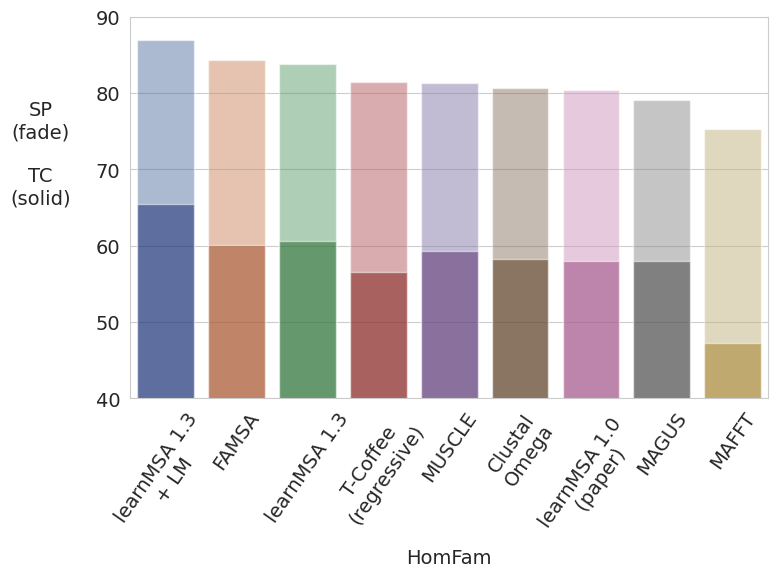

In [23]:
# make a stacked bar plot that compares SP and TC scores for all tools 
# for each dataset
datasets = means.dataset.unique()
sns.set_style("whitegrid")
font = {"size"   : 14}
rc('font', **font)
fig = plt.figure(figsize=(8,6))
#get the permutation that sorts the tools by their mean SP score
sorted_ds_tools = means.groupby(["dataset", "tool"])["SP"].mean().sort_values(ascending=False).index
means_sorted = means.set_index(["dataset", "tool"]).loc[sorted_ds_tools].reset_index()
for i,d in enumerate(datasets):
    data = means_sorted[means_sorted.dataset == d]
    data.tool = data.tool.astype('category')
    data.tool = data.tool.cat.rename_categories({"learnMSA_language" : "learnMSA 1.3\n+ LM", 
                                                 "learnMSA_paper" : "learnMSA 1.0 \n (paper)", 
                                                 "learnMSA" : "learnMSA 1.3", 
                                                 "famsa" : "FAMSA",
                                                 "muscle" : "MUSCLE",
                                                 "clustalo" : "Clustal\nOmega",
                                                 "magus" : "MAGUS",
                                                 "mafft" : "MAFFT",
                                                 "t_coffee" : "T-Coffee\n(regressive)"})
    data.tool = data.tool.astype('object')
    ax = fig.add_subplot(datasets.size, 1, i+1)
    #render sp scores 
    sp = sns.barplot(
        data=data, x="tool", y="SP",
        palette="deep", alpha=.5, ax=ax)
    #render tc scores as stacked bars on top
    tc = sns.barplot(data=data, x="tool", y="TC",
        palette="dark", alpha=.5, ax=ax)
    ax.set_ylim(40, 90)
    ax.set_xlabel({"homfam" : "HomFam"}[d])
    for item in ax.get_xticklabels():
        item.set_rotation(55)
    ax.set_ylabel("SP\n(fade)\n\nTC\n(solid)", rotation=0, labelpad=40)
#save as pdf
plt.tight_layout()
plt.savefig("plots/SP_TC.pdf")
plt.savefig("plots/SP_TC.png")

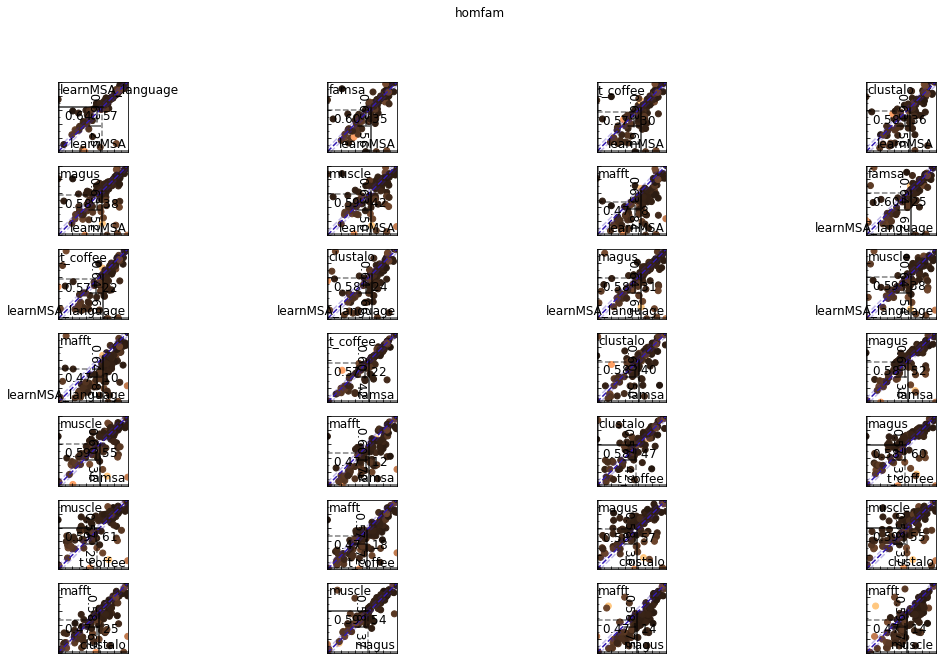

In [ ]:



for d in datasets:
    cmap = cm.get_cmap(name="copper")
    data = pd.concat([dfs[i].loc[dfs[i].dataset == dataset].TC for i in range(len(tools))] + [dfs[0].loc[dfs[0].dataset == dataset].overlength], axis=1)
    numpy_data = data.iloc[:,:-1].to_numpy().transpose() / 100.
    max_val = np.amax(data.iloc[:,-1])
    colors = [cmap(x / max_val)[:-1] for x in data.iloc[:,-1]]

    fig, ax = scatter_comparison(numpy_data, labels=tools, color=colors)
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(dataset)